# Main imports and code - Preparation

In [2]:
# check which gpu we're using
!nvidia-smi

Tue Mar  5 13:54:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install simpletransformers
!pip install tensorboardx
!pip install googletrans
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.

In [4]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import wandb

In [5]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [6]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## Fetch Don't Patronize Me! data manager module

In [7]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [8]:
#the raw dataset
!wget -O dontpatronizeme_pcl.tsv https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv

--2024-03-05 13:55:16--  https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3122842 (3.0M) [text/plain]
Saving to: ‘dontpatronizeme_pcl.tsv’

dontpatronizeme_pcl 100%[===================>]   2.98M  --.-KB/s    in 0.03s   

2024-03-05 13:55:16 (116 MB/s) - ‘dontpatronizeme_pcl.tsv’ saved [3122842/3122842]



In [9]:
# their training selection set - i assume it's for picking up corresponding id from the raw dataset
!wget -O train_semeval_parids-labels.csv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv

--2024-03-05 13:55:16--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241839 (236K) [text/plain]
Saving to: ‘train_semeval_parids-labels.csv’

train_semeval_parid 100%[===================>] 236.17K  --.-KB/s    in 0.003s  

2024-03-05 13:55:16 (88.2 MB/s) - ‘train_semeval_parids-labels.csv’ saved [241839/241839]



In [10]:
#their testing selection set
!wget -O dev_semeval_parids-labels.csv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv

--2024-03-05 13:55:16--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61151 (60K) [text/plain]
Saving to: ‘dev_semeval_parids-labels.csv’

dev_semeval_parids- 100%[===================>]  59.72K  --.-KB/s    in 0.001s  

2024-03-05 13:55:17 (49.0 MB/s) - ‘dev_semeval_parids-labels.csv’ saved [61151/61151]



In [11]:
#testing set
!wget -O task4_test.tsv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv

--2024-03-05 13:55:17--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145277 (1.1M) [text/plain]
Saving to: ‘task4_test.tsv’

task4_test.tsv      100%[===================>]   1.09M  --.-KB/s    in 0.02s   

2024-03-05 13:55:17 (49.8 MB/s) - ‘task4_test.tsv’ saved [1145277/1145277]



In [12]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [13]:
from dont_patronize_me import DontPatronizeMe

In [14]:
dpm = DontPatronizeMe('.', 'task4_test.tsv')

In [15]:
dpm.load_task1()
#Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
#Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.

## Load paragraph IDs

In [16]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [17]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [18]:
data=dpm.train_task1_df

In [19]:
data


,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [20]:
data = data.dropna()

# RAW Dataset - Q1.a Data Analysis Code

In [21]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# label_distribution = data['label'].value_counts()
# orig_label_distribution = data['orig_label'].value_counts()

# # distribution of 'label'
# plt.figure(figsize=(10, 5))
# sns.countplot(x='label', data=data)
# plt.title('Distribution of Label')
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.show()

# # distribution of 'orig_label'
# plt.figure(figsize=(10, 5))
# sns.countplot(x='orig_label', data=data)
# plt.title('Distribution of Original Label')
# plt.xlabel('Original Label')
# plt.ylabel('Count')
# plt.show()


# data['text_length'] = data['text'].apply(len)

# # distribution of keywords
# plt.figure(figsize=(12, 6))
# sns.countplot(data=data, y='keyword', order = data['keyword'].value_counts().index)
# plt.title('Distribution of Keywords')
# plt.xlabel('Count')
# plt.ylabel('Keyword')
# plt.show()

# # distribution of countries
# plt.figure(figsize=(12, 6))
# sns.countplot(data=data, y='country', order = data['country'].value_counts().index)
# plt.title('Distribution of Countries')
# plt.xlabel('Count')
# plt.ylabel('Country')
# plt.show()

# # distribution of text lengths
# plt.figure(figsize=(12, 6))
# sns.histplot(data=data, x='text_length', bins=50, kde=True)
# plt.title('Distribution of Text Lengths')
# plt.xlabel('Text Length')
# plt.ylabel('Count')
# plt.show()


In [22]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# mean_length = data['text_length'].mean()
# std_dev_length = data['text_length'].std()

# threshold = mean_length + std_dev_length

# data['text_length_category'] = data['text_length'].apply(lambda x: 'long' if x > threshold else 'short')
# #.map({'long': 1, 'short': 0})


In [23]:

# contingency_table = pd.crosstab(data['text_length_category'], data['label'])

# plt.figure(figsize=(10, 6))
# sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='g')
# plt.title('Distribution of Labels within Text Length Categories')
# plt.xlabel('Label')
# plt.ylabel('Text Length Category')
# plt.show()



In [24]:
# contingency_table_orig_label = pd.crosstab(data['text_length_category'], data['orig_label'])


# plt.figure(figsize=(12, 8))
# sns.heatmap(contingency_table_orig_label, annot=True, cmap='Blues', fmt='g')
# plt.title('Distribution of Original Labels within Text Length Categories')
# plt.xlabel('Original Label')
# plt.ylabel('Text Length Category')
# plt.show()


In [25]:

# contingency_table_country = pd.crosstab(data['country'], data['text_length_category'])

# plt.figure(figsize=(12, 8))
# sns.heatmap(contingency_table_country, annot=True, cmap='Greens', fmt='g')
# plt.title('Distribution of Text Length within Countries')
# plt.xlabel('Text Length')
# plt.ylabel('Country')
# plt.show()


In [26]:

# contingency_table_keyword = pd.crosstab(data['keyword'],data['text_length_category'])

# plt.figure(figsize=(12, 8))
# sns.heatmap(contingency_table_keyword, annot=True, cmap='Purples', fmt='g')
# plt.title('Distribution of Text Length within Keywords')
# plt.xlabel('Text Length')
# plt.ylabel('Keyword')
# plt.show()




## Get the raw training set (Task 1) - without split

In [27]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [28]:
import random

In [29]:
trdf1 = pd.DataFrame(rows)

In [30]:
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


In [31]:
trdf1.to_csv("trdf1.csv")

## get the raw test set (Task 1)

In [32]:
rows = [] # will contain par_id, label and text

for idx in range(len(teids)):
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  orig_label = data.loc[data.par_id == parid].orig_label.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'orig_label':orig_label,
      'label':label
  })


In [33]:
len(rows)

2094

In [34]:
tedf1 = pd.DataFrame(rows)
print(tedf1)

     par_id   community                                               text  \
0      4046    hopeless  We also know that they can benefit by receivin...   
1      1279     refugee  Pope Francis washed and kissed the feet of Mus...   
2      8330     refugee  Many refugees do n't want to be resettled anyw...   
3      4063     in-need  "Budding chefs , like "" Fred "" , "" Winston ...   
4      4089    homeless  "In a 90-degree view of his constituency , one...   
...     ...         ...                                                ...   
2089  10462    homeless  The sad spectacle , which occurred on Saturday...   
2090  10463     refugee  """ The Pakistani police came to our house and...   
2091  10464    disabled  "When Marie O'Donoghue went looking for a spec...   
2092  10465       women  "Sri Lankan norms and culture inhibit women fr...   
2093  10466  vulnerable  He added that the AFP will continue to bank on...   

     orig_label  label  
0             3      1  
1            

In [35]:
random.shuffle(tedf1.text.tolist())
tedf1.to_csv("tedf1.csv")
#shuffled_tedf1 = tedf1.sample(frac=1).reset_index(drop=True)

In [36]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


def evaluate_model(true_labels, preds):
    f1 = f1_score(true_labels, preds)
    accuracy = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    conf_matrix = confusion_matrix(true_labels, preds)
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


    print("Confusion Matrix:")
    print(conf_matrix)

def compute_metrics(p):
    predictions = p.predictions.argmax(axis=1)
    labels = p.label_ids

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')


    # return {"accuracy": accuracy, "f1": f1, "predictions": list(predictions)}
    return {"accuracy": accuracy, "f1": f1}



## RoBERTa Baseline with Downsampled raw data for Task 1

In [37]:
print(len(trdf1[trdf1.label==0]))
print(len(trdf1[trdf1.label==1]))
print((len(trdf1[trdf1.label==0]))/len(trdf1[trdf1.label==1]))

7581
794
9.547858942065492


Neg is 10 times more than positive class.

### RoBERTa Negative : Positive = 2:1

- non-pcl : pcl = 2:1
- 46.7% F1 on offical dev set

In [38]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)
#0, limited to twice the number of positive examples
training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [39]:
# from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs

# task1_model_args = ClassificationArgs(num_train_epochs=1,
#                                       no_save=True,
#                                       no_cache=True,
#                                       overwrite_output_dir=True,
#                                       use_multiprocessing=False,
#                                       use_multiprocessing_for_evaluation=False)
# task1_model = ClassificationModel("roberta",
#                                   'roberta-base',
#                                   args = task1_model_args,
#                                   num_labels=2,
#                                   use_cuda=cuda_available)
# # train model
# task1_model.train_model(training_set1[['text', 'label']])
# # run predictions
# preds_task1, _ = task1_model.predict(tedf1.text.tolist())

In [40]:
#labels2file([[k] for k in preds_task1], 'task1.txt')

In [41]:
# true_labels = tedf1.label.tolist()
# print(true_labels)
# evaluate_model(true_labels, preds_task1)

In [42]:
#training_set2 = pd.concat([pcldf,trdf1[trtedf1.label==0][:npos*3]])

### RoBERTa Negative : Positive = 3:1
- change ratio to 3:1
- F1: 52.21%

In [43]:
# training_set2 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*3]])

# # train model
# task1_model.train_model(training_set2[['text', 'label']])
# # run predictions
# preds_task1, _ = task1_model.predict(tedf1.text.tolist())
# true_labels = tedf1.label.tolist()
# evaluate_model(true_labels, preds_task1)

In [44]:
# print(len(training_set1[training_set1.label==0]))
# print(len(training_set1[training_set1.label==1]))
# print((len(training_set1[training_set1.label==0]))/len(training_set1[training_set1.label==1]))

In [45]:
# print(len(training_set2[training_set2.label==0]))
# print(len(training_set2[training_set2.label==1]))
# print((len(training_set2[training_set2.label==0]))/len(training_set2[training_set2.label==1]))

# Get Train + Val + Test Set

In [46]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(trdf1, test_size=0.2, random_state=905)
test_set = tedf1
print(test_set)

     par_id   community                                               text  \
0      4046    hopeless  We also know that they can benefit by receivin...   
1      1279     refugee  Pope Francis washed and kissed the feet of Mus...   
2      8330     refugee  Many refugees do n't want to be resettled anyw...   
3      4063     in-need  "Budding chefs , like "" Fred "" , "" Winston ...   
4      4089    homeless  "In a 90-degree view of his constituency , one...   
...     ...         ...                                                ...   
2089  10462    homeless  The sad spectacle , which occurred on Saturday...   
2090  10463     refugee  """ The Pakistani police came to our house and...   
2091  10464    disabled  "When Marie O'Donoghue went looking for a spec...   
2092  10465       women  "Sri Lankan norms and culture inhibit women fr...   
2093  10466  vulnerable  He added that the AFP will continue to bank on...   

     orig_label  label  
0             3      1  
1            

In [47]:
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)
print(test_set.columns)

(6700, 4)
(1675, 4)
(2094, 5)
Index(['par_id', 'community', 'text', 'orig_label', 'label'], dtype='object')


In [48]:
# model_args = ClassificationArgs(
#           num_train_epochs = 4,
#           learning_rate = 2e-5,
#           overwrite_output_dir = True,
#           evaluate_during_training = True,
#           manual_seed = 42,
#           use_early_stopping = True,
#           early_stopping_consider_epochs = True,
#           early_stopping_patience = 3,
#           save_steps = -1 , # Save the model only at the end of training
#           train_batch_size = 16,
#           eval_batch_size = 8
# )


# model = ClassificationModel('electra', 'google/electra-small-discriminator', args=model_args,num_labels=2,
#                                   use_cuda=cuda_available)


# model.train_model(train_set[['text', 'label']], eval_df = val_set[['text', 'label']])

# predictions, raw_outputs = model.predict(test_set['text'].tolist())
# evaluate_model(test_set['label'].tolist(),predictions )

# Q2.a & b

## Deberta - on our splitted dataset

- 57.36%

In [49]:
deberta_model_args = ClassificationArgs(
    num_train_epochs=4,
    learning_rate=2e-5,
    train_batch_size=32,
    early_stopping_patience=3,  # Adjusted for early stopping
    overwrite_output_dir=True,
    evaluate_during_training=True,
    manual_seed=42,
    use_early_stopping=True,
    early_stopping_consider_epochs=True,
    save_steps=-1,  # Save the model only at the end of training
    eval_batch_size=16,  # Keeping fixed as per your reference args
    use_multiprocessing=False,
    use_multiprocessing_for_evaluation=False
)
deberta_model = ClassificationModel(
'deberta',
'microsoft/deberta-base',
args=deberta_model_args,
num_labels=2,
use_cuda=cuda_available
)
deberta_model.train_model(train_set[['text', 'label']], eval_df=val_set[['text', 'label']])
result, model_outputs, wrong_predictions = deberta_model.eval_model(val_set[['text', 'label']])
print(result)
print(test_set.columns)
predictions_deberta, raw_outputs = deberta_model.predict(test_set['text'].tolist())
print(test_set.columns)
evaluate_model(test_set['label'].tolist(),predictions_deberta)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/210 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Epoch 2 of 4:   0%|          | 0/210 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Epoch 3 of 4:   0%|          | 0/210 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Epoch 4 of 4:   0%|          | 0/210 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

{'mcc': 0.48676496398323293, 'accuracy': 0.9122388059701493, 'f1_score': 0.5333333333333333, 'tp': 84, 'tn': 1444, 'fp': 62, 'fn': 85, 'auroc': 0.8952375900736305, 'auprc': 0.590654582465718, 'eval_loss': 0.3580151883486126}
Index(['par_id', 'community', 'text', 'orig_label', 'label'], dtype='object')


  0%|          | 0/131 [00:00<?, ?it/s]

Index(['par_id', 'community', 'text', 'orig_label', 'label'], dtype='object')
F1 Score: 0.581151832460733
Accuracy: 0.9235912129894938
Precision: 0.6065573770491803
Recall: 0.5577889447236181
Confusion Matrix:
[[1823   72]
 [  88  111]]


## Anlaysis Q3

object
Unique values in 'orig_label' before conversion: ['3' '4' '2' '0' '1']
Metrics by Level of Patronizing Content:
             Accuracy  F1 Score
orig_label                    
High        0.728261  0.842767
Low         0.166667  0.285714
Moderate    0.460674  0.630769
No PCL      0.962005  0.000000


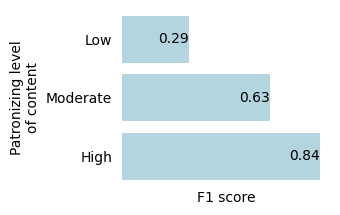

Metrics by Data Category:
                Accuracy  F1 Score
community                        
disabled       0.948454  0.545455
homeless       0.863208  0.539683
hopeless       0.894009  0.549020
immigrant      0.981651  0.600000
in-need        0.902655  0.702703
migrant        0.985507  0.571429
poor-families  0.836842  0.550725
refugee        0.930851  0.480000
vulnerable     0.942584  0.700000
women          0.944206  0.380952


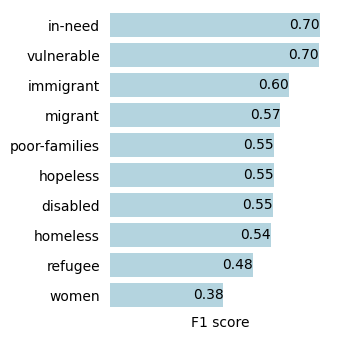

Metrics by Input Sequence Length:
                  Accuracy  F1 Score
length_category                    
Very Short       0.934551  0.619469
Short            0.918261  0.548077
Medium           0.922481  0.705882
Long             0.937500  0.666667
  length_category     score
2          Medium  0.705882
3            Long  0.666667
0      Very Short  0.619469
1           Short  0.548077


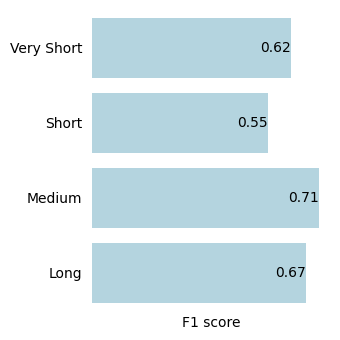

In [59]:
import seaborn as sns
# Assuming predictions_deberta corresponds to the predictions made on val_set
import pandas as pd
test_set_copy=test_set.copy()
test_set_copy['predictions'] = predictions_deberta
print(test_set_copy['orig_label'].dtype)

print("Unique values in 'orig_label' before conversion:", test_set_copy['orig_label'].unique())

test_set_copy['orig_label'] = pd.to_numeric(test_set_copy['orig_label'].replace('None', pd.NA), errors='coerce')

# For simplicity, assuming 2 = 'Low', 3 = 'Moderate', 4 = 'High'
test_set_copy['orig_label'] = test_set_copy['orig_label'].map({0: 'No PCL', 1: 'No PCL',2: 'Low', 3: 'Moderate', 4: 'High'})

# Function to calculate accuracy and F1 score for a given group
def calculate_metrics(group):
    accuracy = accuracy_score(group['label'], group['predictions'])
    f1 = f1_score(group['label'], group['predictions'], average='binary', pos_label=1)  # Adjust pos_label as necessary
    return pd.Series({'Accuracy': accuracy, 'F1 Score': f1})

# Calculate accuracy and F1 score for each level of patronizing content
metrics_by_level = test_set_copy.groupby('orig_label').apply(calculate_metrics)

print("Metrics by Level of Patronizing Content:\n", metrics_by_level)

import matplotlib.pyplot as plt

# Extract the 'F1 Score' for plotting
f1_scores = metrics_by_level['F1 Score']
f1_scores = metrics_by_level.reindex(['No PCL', 'Low', 'Moderate', 'High'])['F1 Score']
f1_scores = f1_scores.reset_index()
f1_scores.rename(columns={'F1 Score': 'score'}, inplace=True)
f1_scores = f1_scores.iloc[1:]

# Create a horizontal bar plot
plt.figure(figsize=(3.5, 2.25))
barplot = sns.barplot(x='score', y='orig_label', data=f1_scores, orient='h', color='lightblue')
plt.title('')
plt.xlabel('F1 score')
plt.ylabel('Patronizing level\nof content')
plt.xticks([])
for p in barplot.patches:
    width = p.get_width()  # Get bar width
    plt.text(width if width > 0.1 else width + 0.1,  # Adjust x position based on width
             p.get_y() + p.get_height() / 2,  # y position
             f"{width:.2f}",  # Text to display
             ha='right' if width > 0.1 else 'left',  # Adjust alignment based on width
             va='center',
             color='black')
plt.gca().tick_params(left=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
#plt.savefig('/vol/bitbucket/mdh323/SemEval-2022-Task-4/f1_by_content.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Analyze Model Performance Based on Data Categories
# Calculate accuracy and F1 score for each data category
def calculate_category_metrics(group):
    accuracy = accuracy_score(group['label'], group['predictions'])
    f1 = f1_score(group['label'], group['predictions'], average='binary', pos_label=1)  # Adjust pos_label as necessary
    return pd.Series({'Accuracy': accuracy, 'F1 Score': f1})

metrics_by_category = test_set_copy.groupby('community', observed=True).apply(calculate_category_metrics)
print("Metrics by Data Category:\n", metrics_by_category)

import matplotlib.pyplot as plt

# Assuming 'metrics_by_category' DataFrame with 'community' as index and 'F1 Score' as a column
# Extract the 'F1 Score' for plotting
f1_scores = metrics_by_category['F1 Score']
f1_scores = f1_scores.reset_index()
f1_scores.rename(columns={'F1 Score': 'score'}, inplace=True)
f1_scores = f1_scores.sort_values('score', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(3.5, 3.5))
barplot = sns.barplot(x='score', y='community', data=f1_scores, orient='h', color='lightblue')
plt.title('')
plt.xlabel('F1 score')
plt.ylabel('')
plt.xticks([])
for p in barplot.patches:
    width = p.get_width()  # Get bar width
    plt.text(width if width > 0.1 else width + 0.1,  # Adjust x position based on width
             p.get_y() + p.get_height() / 2,  # y position
             f"{width:.2f}",  # Text to display
             ha='right' if width > 0.1 else 'left',  # Adjust alignment based on width
             va='center',
             color='black')
plt.gca().tick_params(left=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
#plt.savefig('/vol/bitbucket/mdh323/SemEval-2022-Task-4/f1_by_category.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Analyze Impact of Input Sequence Length
test_set_copy['text_length'] = test_set_copy['text'].apply(len)
# Categorize text lengths into bins for simplicity
test_set_copy['length_category'] = pd.cut(test_set_copy['text_length'], bins=[100, 200, 500, 800, max(test_set_copy['text_length'])], labels=['Very Short','Short', 'Medium', 'Long'])

# Calculate accuracy and F1 score for each length category
def calculate_length_metrics(group):
    accuracy = accuracy_score(group['label'], group['predictions'])
    f1 = f1_score(group['label'], group['predictions'], average='binary', pos_label=1)  # Adjust pos_label as necessary
    return pd.Series({'Accuracy': accuracy, 'F1 Score': f1})

metrics_by_length = test_set_copy.groupby('length_category',observed=True).apply(calculate_length_metrics)
print("Metrics by Input Sequence Length:\n", metrics_by_length)

import matplotlib.pyplot as plt

# Assuming 'metrics_by_length' is indexed by 'length_category' and contains a column 'F1 Score'
f1_scores = metrics_by_length['F1 Score']

f1_scores = f1_scores.reset_index()
f1_scores.rename(columns={'F1 Score': 'score'}, inplace=True)
f1_scores = f1_scores.sort_values('score', ascending=False)
print(f1_scores)

# Create a horizontal bar plot
plt.figure(figsize=(3.5, 3.5))
barplot = sns.barplot(x='score', y='length_category', data=f1_scores, orient='h', color='lightblue')
plt.title('')
plt.xlabel('F1 score')
plt.ylabel('')
plt.xticks([])
for p in barplot.patches:
    width = p.get_width()  # Get bar width
    plt.text(width if width > 0.1 else width + 0.1,  # Adjust x position based on width
             p.get_y() + p.get_height() / 2,  # y position
             f"{width:.2f}",  # Text to display
             ha='right' if width > 0.1 else 'left',  # Adjust alignment based on width
             va='center',
             color='black')
plt.gca().tick_params(left=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
#plt.savefig('/vol/bitbucket/mdh323/SemEval-2022-Task-4/f1_by_text_length.pdf', format='pdf', bbox_inches='tight')
plt.show()

Metrics by Data Category:
                Accuracy  F1 Score
community                        
disabled       0.948454  0.545455
homeless       0.863208  0.539683
hopeless       0.894009  0.549020
immigrant      0.981651  0.600000
in-need        0.902655  0.702703
migrant        0.985507  0.571429
poor-families  0.836842  0.550725
refugee        0.930851  0.480000
vulnerable     0.942584  0.700000
women          0.944206  0.380952


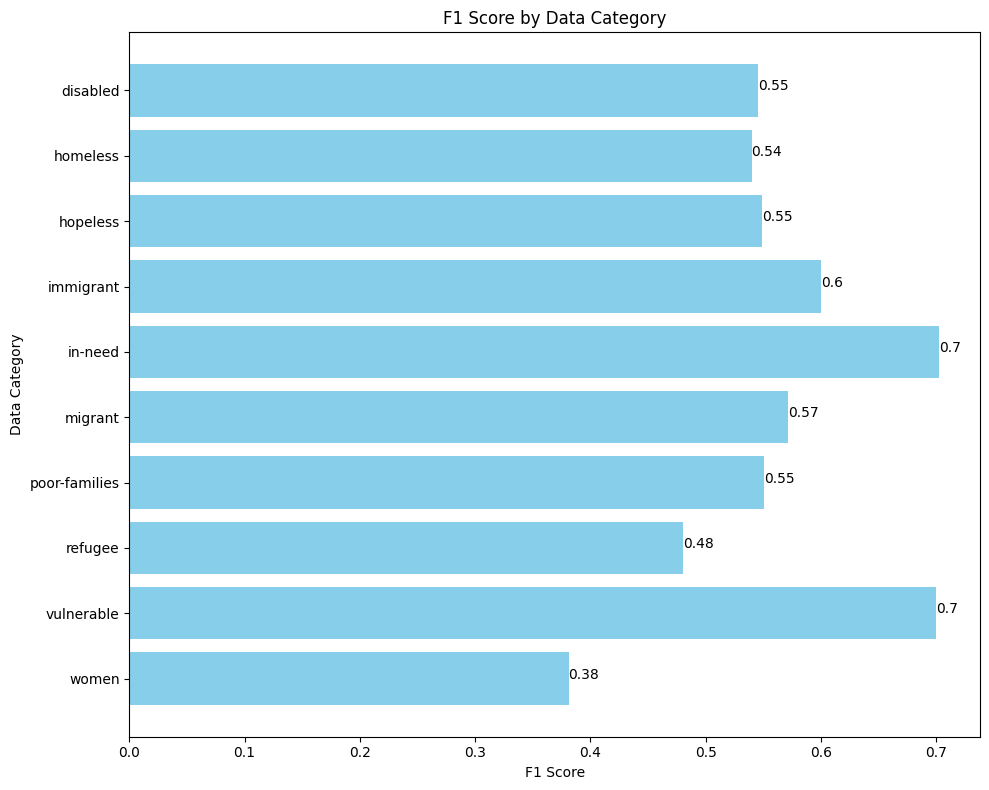

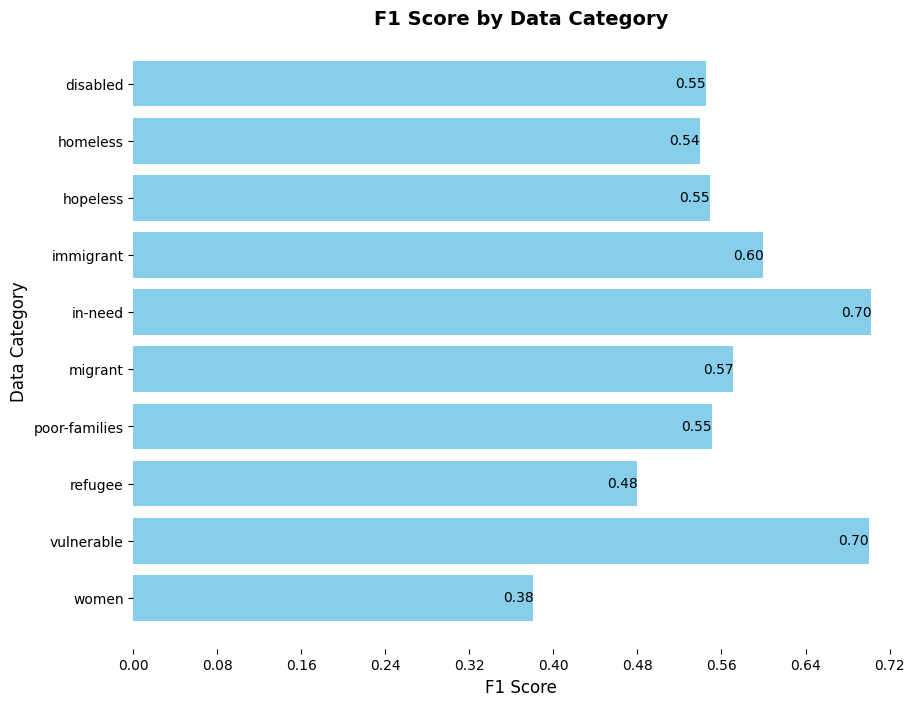

In [60]:
# Analyze Model Performance Based on Data Categories
# Calculate accuracy and F1 score for each data category
def calculate_category_metrics(group):
    accuracy = accuracy_score(group['label'], group['predictions'])
    f1 = f1_score(group['label'], group['predictions'], average='binary', pos_label=1)  # Adjust pos_label as necessary
    return pd.Series({'Accuracy': accuracy, 'F1 Score': f1})

metrics_by_category = test_set_copy.groupby('community', observed=True).apply(calculate_category_metrics)
print("Metrics by Data Category:\n", metrics_by_category)

import matplotlib.pyplot as plt

# Assuming 'metrics_by_category' DataFrame with 'community' as index and 'F1 Score' as a column
f1_scores = metrics_by_category['F1 Score']

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))  # Adjust the figure size as necessary
plt.barh(f1_scores.index, f1_scores, color='skyblue')  # You can choose different colors

# Add data labels to each bar
for index, value in enumerate(f1_scores):
    plt.text(value, index, str(round(value, 2)))

plt.title('F1 Score by Data Category')
plt.xlabel('F1 Score')
plt.ylabel('Data Category')

# Invert y-axis to have the highest value on top if preferred
plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the labels
plt.show()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming 'metrics_by_category' DataFrame with 'community' as index and 'F1 Score' as a column
f1_scores = metrics_by_category['F1 Score']

# Create a horizontal bar plot with a minimalistic style
plt.figure(figsize=(10, 8))
bars = plt.barh(f1_scores.index, f1_scores, color='skyblue', edgecolor='none')  # No borders on bars

# Remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add data labels to each bar
for bar in bars:
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height()/2,
        f'{bar.get_width():.2f}',
        va='center', ha='right', color='black'
    )

# Set the background color to white
plt.gca().set_facecolor('white')
plt.grid(visible=False)  # Hide gridlines

# Show only the left and bottom ticks
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

# Set the title and labels with adjusted font sizes
plt.title('F1 Score by Data Category', fontsize=14, fontweight='bold')
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Data Category', fontsize=12)

# Invert y-axis to have the highest value on top if preferred
plt.gca().invert_yaxis()

# Adjust the layout to make room for the labels
plt.show()



Metrics by Input Sequence Length:
                  Accuracy  F1 Score
length_category                    
Very Short       0.934551  0.619469
Short            0.918261  0.548077
Medium           0.922481  0.705882
Long             0.937500  0.666667


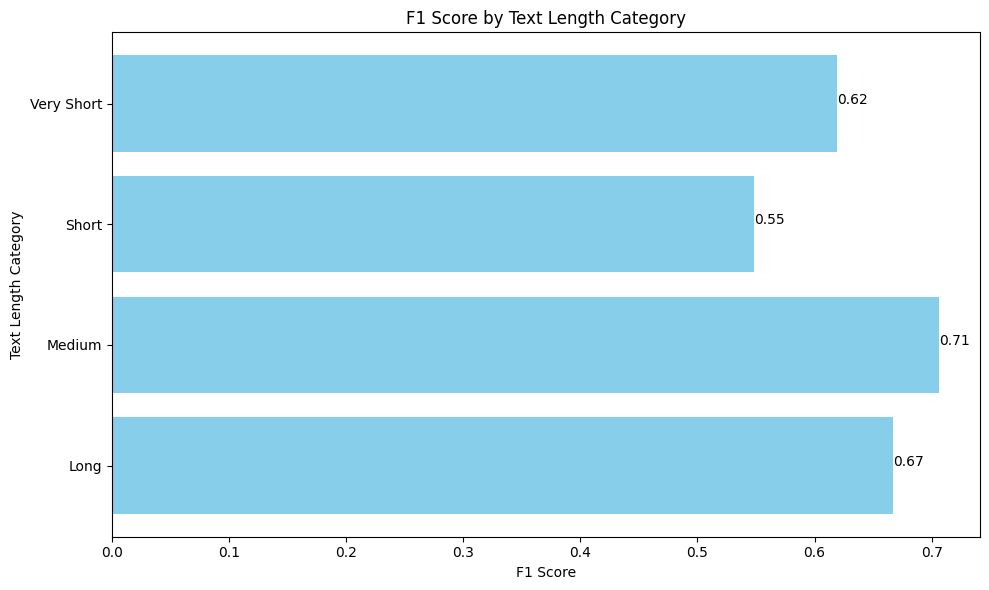

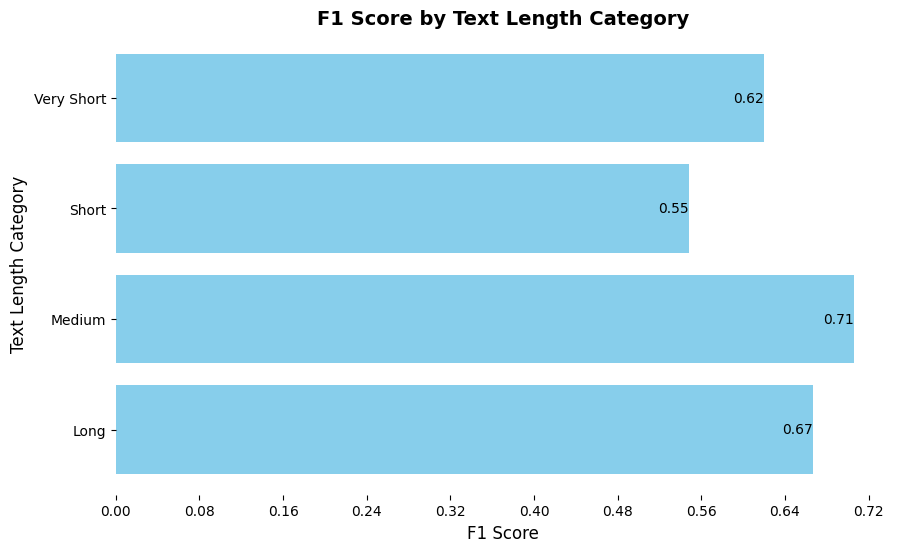

In [61]:

# Analyze Impact of Input Sequence Length
test_set_copy['text_length'] = test_set_copy['text'].apply(len)
# Categorize text lengths into bins for simplicity
test_set_copy['length_category'] = pd.cut(test_set_copy['text_length'], bins=[100, 200, 500, 800, max(test_set_copy['text_length'])], labels=['Very Short','Short', 'Medium', 'Long'])

# Calculate accuracy and F1 score for each length category
def calculate_length_metrics(group):
    accuracy = accuracy_score(group['label'], group['predictions'])
    f1 = f1_score(group['label'], group['predictions'], average='binary', pos_label=1)  # Adjust pos_label as necessary
    return pd.Series({'Accuracy': accuracy, 'F1 Score': f1})

metrics_by_length = test_set_copy.groupby('length_category',observed=True).apply(calculate_length_metrics)
print("Metrics by Input Sequence Length:\n", metrics_by_length)

import matplotlib.pyplot as plt

# Assuming 'metrics_by_length' is indexed by 'length_category' and contains a column 'F1 Score'
f1_scores = metrics_by_length['F1 Score']

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
plt.barh(f1_scores.index, f1_scores, color='skyblue')  # This will create horizontal bars

# Add data labels to each bar
for index, value in enumerate(f1_scores):
    plt.text(value, index, f'{value:.2f}')  # Formatting the value to 2 decimal places

plt.title('F1 Score by Text Length Category')
plt.xlabel('F1 Score')
plt.ylabel('Text Length Category')

# Invert y-axis to have the highest value on top if preferred
plt.gca().invert_yaxis()

# Adjust layout and display the plot
plt.tight_layout()  # Adjust the layout to make room for the labels
plt.show()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming 'metrics_by_length' is indexed by 'length_category' and contains a column 'F1 Score'
f1_scores = metrics_by_length['F1 Score']

# Create a horizontal bar plot with a clean, minimalistic style
plt.figure(figsize=(10, 6))
bars = plt.barh(f1_scores.index, f1_scores, color='skyblue', edgecolor='none')  # No borders on bars

# Remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add data labels to each bar
for bar in bars:
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}',
        va='center', ha='right', color='black'
    )

# Set the background color to white
plt.gca().set_facecolor('white')
plt.grid(visible=False)  # Hide gridlines

# Show only the left and bottom ticks
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

# Set the title and labels with adjusted font sizes
plt.title('F1 Score by Text Length Category', fontsize=14, fontweight='bold')
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Text Length Category', fontsize=12)

# Invert y-axis to have the longest texts at the bottom and shortest at the top
plt.gca().invert_yaxis()

# Show the plot without tight_layout to prevent clipping of labels
plt.show()



# Prepare submission

In [ ]:
!cat dev.txt | head -n 10

In [ ]:
!zip submission.zip dev.txt test.txt

In [ ]:
!cat test.txt | head -n 10